<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 4: Web Scraping Job Postings

Detailed instructions are in Readme.md 
My answers for this Project are split into several notebooks to make it easier to review key sections and make changes where needed. In 2.0, I work on building the models to answer Question 1.

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import scipy as sp
import scipy.stats as stats
import seaborn as sns

from scipy.sparse.csr import csr_matrix
from scipy.sparse import hstack, vstack
from sklearn import metrics
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.ensemble import RandomForestClassifier 
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, mean_squared_error, precision_score, recall_score
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, LinearSVC

mpl.rcParams["figure.dpi"] = 300
%matplotlib inline
%config InlineBackend.figure_format ='retina'

In [2]:
jobs = pd.read_csv('../data/jobs_clean.csv')

# QUESTION 1: Predicting high salaried jobs in the data industry
I'll address Question 1 by building models to predict high salaries, which is what job seekers are interested in. Who cares about predicting low salaries, right?. 

Since there's no standard definition of "high salary" for the data industry, I'll define one: 1 standard deviation above the median for average salary, ie, 9,850 Sing dollars (6,750 (median) + 3099.8 (std)).

Next, I'll create a new col indicating whether a job posting has a high salary, or not.  

In [3]:
jobs['High_Salary_Or_Not'] = np.where(jobs['Salary_Average'] > 9850, 1, 0)

In [4]:
jobs['High_Salary_Or_Not'].value_counts()

0    649
1    163
Name: High_Salary_Or_Not, dtype: int64

In [5]:
jobs.head()

,Company,Title,Responsibilities,Requirements,Seniority,Employment_Type,Category,Address,Salary_Min,Salary_Max,Salary_Average,High_Salary_Or_Not
0,Hitachi Consulting Singapore,Data Scientist,Problem solver with curious mindset with a hi...,Sound knowledge of machine learning concepts ...,Senior Executive,Permanent,Information Technology,Plaza 8 Cbp 1 Changi Business Park Crescent 4...,6000.0,9000.0,7500.0,0
1,Traveloka Services,Data Science Lead,As a Data scientist you play a key role to sol...,We are looking for someone with Passion in bi...,Manager,Permanent,Information Technology,Undisclosed,10000.0,15000.0,12500.0,1
2,Traveloka Services,Senior Data Scientist,Job Description As a Data scientist you will b...,Solid programming skills and understanding o...,Executive,Permanent,Information Technology,Undisclosed,8300.0,15000.0,11650.0,1
3,Traveloka Services,Mid - Senior Level Data Scientist,As a Data scientist you will be applying machi...,Solid programming skills and understanding o...,Executive,Permanent,Information Technology,Undisclosed,6100.0,10700.0,8400.0,0
4,Traveloka Services,Mid Level Data Scientist,As a Data scientist you will be applying machi...,Solid programming skills and understanding o...,Executive,Permanent,Information Technology,Undisclosed,4300.0,7600.0,5950.0,0


#### NOTE: 
We are naturally dealing with an imbalanced class here, as high-paying jobs are obviously harder to come by - just 25% of the dataset. Subsequent modelling and analysis of the confusion matrices will have to take note of this. 

Let's start with four predictors identified from the EDA phase, and progressively move to more complex models with more features.

In [6]:
predictors = ['Company', 'Title', 'Seniority', 'Category']

In [7]:
# Since I'll be using a non-linear model like Random Forest, I won't apply the drop_first parameter 
job_predictors = pd.get_dummies(jobs[predictors])

In [8]:
X = job_predictors
y = jobs['High_Salary_Or_Not']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [10]:
print((X_train.shape))
print((X_test.shape))

(609, 1004)
(203, 1004)


In [11]:
print(y_test.value_counts())

0    162
1     41
Name: High_Salary_Or_Not, dtype: int64


The more important benchmarks for the models would be the Recall and Precision scores, ie, how many of the 41 high salaries in the target test set can it predict without picking out too many false alarms?

#### 1.1 BUILDING BASELINE PERFORMANCE VIA DUMMY CLASSIFIER

In [12]:
dummy = DummyClassifier(strategy='stratified', random_state=42)

In [13]:
dummy.fit(X_train, y_train)

DummyClassifier(constant=None, random_state=42, strategy='stratified')

In [14]:
dummy_pred = dummy.predict(X_test)

In [15]:
print("Accuracy Score:", accuracy_score(y_test, dummy_pred))
print("Precision Score : ", precision_score(y_test, dummy_pred))
print("Recall Score:", recall_score(y_test, dummy_pred))
print("f1 Score:", f1_score(y_test, dummy_pred))

Accuracy Score: 0.6798029556650246
Precision Score :  0.21428571428571427
Recall Score: 0.21951219512195122
f1 Score: 0.21686746987951805


#### BASELINE INDICATORS:

We can expect subsequent classifier models to score high on the accuracy score, given that the dummy model's accuracy score is already 0.68. But in this case, we know that the Recall and Precision scores are more important as we are trying to predict for high salaries, instead of average or low-paying salaries which form the majority class. 

#### 1.2 TRYING A TRIO OF MODELS
Since this is an imbalanced class, I'll factor in class weightage in the testing of the models as well.

In [16]:
models = {
    "Log_Reg": (
        LogisticRegression(),
        {
            "penalty": ["l1", "l2"],
            "C": np.logspace(-4, 4, 40),
            "solver": ["liblinear"],
            "class_weight": [None, "balanced", {0: 1, 1: 75}],
        },
    ),
    "LinearSVC": (
        LinearSVC(),
        {
            "C": [10.0, 1.0, 0.1, 0.001],
            "loss": ["squared_hinge"],
            "class_weight": [None, "balanced", {0: 1, 1: 75}],
        },
    ),
    "Random Forest": (
        RandomForestClassifier(),
        {
            "n_estimators": [200, 500, 1000],
            "criterion": ["gini", "entropy"],
            "class_weight": [None, "balanced", {0: 1, 1: 75}],
        },
    ),
}

In [17]:
for name, (model, parameters) in models.items():
    print("----- {} -----".format(name))
    gs = GridSearchCV(model, parameters, cv=5, verbose=0, n_jobs=-1, scoring="roc_auc")
    gs.fit(X_train, y_train)
    print("Best Parameters:", gs.best_params_)
    print("Best Score:", gs.best_score_)
    y_pred = gs.predict(X_test)
    print("Precision Score :", precision_score(y_test, y_pred))
    print("Recall Score:", recall_score(y_test, y_pred))
    print("f1 Score:", f1_score(y_test, y_pred))
    print("")

----- Log_Reg -----


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best Parameters: {'C': 8.376776400682925, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}
Best Score: 0.8207478127777105
Precision Score : 0.6388888888888888
Recall Score: 0.5609756097560976
f1 Score: 0.5974025974025975

----- LinearSVC -----


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best Parameters: {'C': 0.1, 'class_weight': {0: 1, 1: 75}, 'loss': 'squared_hinge'}
Best Score: 0.8189831755497723
Precision Score : 0.44
Recall Score: 0.8048780487804879
f1 Score: 0.5689655172413793

----- Random Forest -----


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best Parameters: {'class_weight': None, 'criterion': 'gini', 'n_estimators': 200}
Best Score: 0.798353593058099
Precision Score : 0.7894736842105263
Recall Score: 0.36585365853658536
f1 Score: 0.4999999999999999



### ANALYSIS:
Of the 3 models, the Random Forest had the best precision score - by a significant margin. Let's see the detailed predictions in this model. 

#### 1.3 RFC WITH 4 PREDICTORS

In [18]:
rfc_grid = dict(
    n_estimators=[1000],
    criterion=['entropy'],
    class_weight=['balanced']
)

In [19]:
rfc = RandomForestClassifier(random_state=0, n_jobs=-1)

In [20]:
clf = GridSearchCV(rfc, rfc_grid, cv=5, scoring='roc_auc', verbose=1, n_jobs=-1)

In [21]:
clf.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.4s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [1000], 'criterion': ['entropy'], 'class_weight': ['balanced']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [22]:
clf.best_params_

{'class_weight': 'balanced', 'criterion': 'entropy', 'n_estimators': 1000}

In [23]:
clf.best_score_

0.7903334600645736

In [24]:
y_pred = clf.predict(X_test)

In [25]:
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("Precision Score :", precision_score(y_test, y_pred))
print("Recall Score:", recall_score(y_test, y_pred))
print("f1 Score:", f1_score(y_test, y_pred))

Accuracy Score: 0.8571428571428571
Precision Score : 0.8
Recall Score: 0.3902439024390244
f1 Score: 0.5245901639344263


In [26]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[158,   4],
       [ 25,  16]])

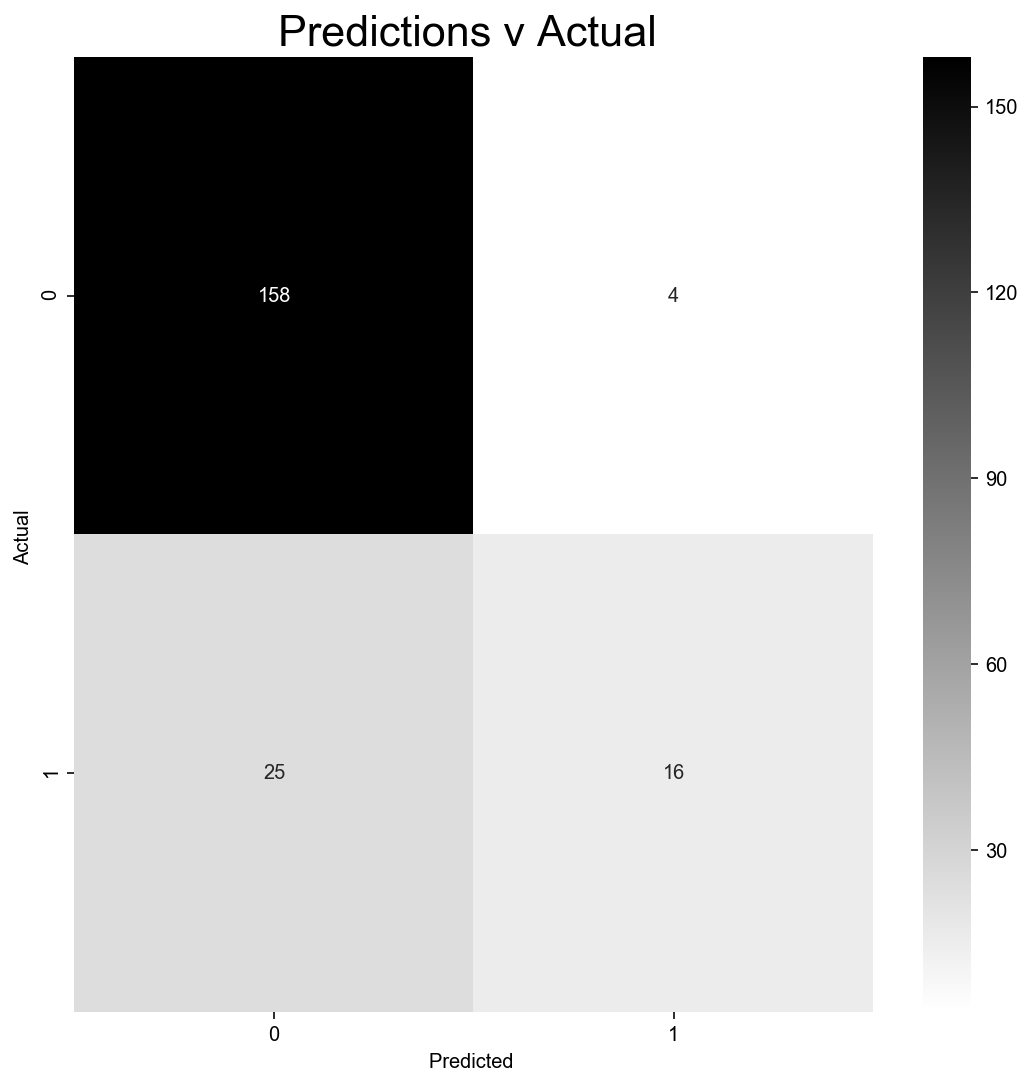

In [27]:
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="gist_gray_r")
sns.set(font_scale=1.8)
plt.title("Predictions v Actual ")
plt.ylabel("Actual ")
plt.xlabel("Predicted ")
plt.tight_layout()

### ANALYSIS:
This outcome looks like a good balance. Of the 20 times that the model predicted jobs with high salaries, 16 of them were correct (true positives), while 4 were false alarms. The model also accurately classified the vast majority of low-average salaried jobs.

We can tweak the class weightage to allow the model to pick out more true positives, or high salaried jobs. But that would come at a cost of creating more "false alarms" or false positives, ie, predicting a job to be high paying when it actually isn't. This would hurt the model's credibility for users. 

It would come down to a business decision as to whether it's worth the reputational risk to try to predict for more high-salaried jobs. 

#### 1.4 WHICH FEATURES ARE MOST CORRELATED WITH HIGH SALARIES?

In [28]:
features = X_train.columns
features

Index(['Company_99 ', 'Company_A*Star Research Entities',
       'Company_A-It Software Services ', 'Company_Accenture ',
       'Company_Acetech Manpower Consultancy ',
       'Company_Achieve Career Consultant ',
       'Company_Acronis Asia Research And Development ',
       'Company_Ad Astra Consultants Private ', 'Company_Adecco Personnel ',
       'Company_Affle International ',
       ...
       'Category_Others Sciences  Laboratory  RD',
       'Category_Professional Services', 'Category_Purchasing  Merchandising',
       'Category_Real Estate  Property Management', 'Category_Risk Management',
       'Category_Risk Management Banking and Finance',
       'Category_Sales  Retail ', 'Category_Sciences  Laboratory  RD',
       'Category_Social Services Healthcare  Pharmaceutical Others',
       'Category_Telecommunications'],
      dtype='object', length=1004)

In [29]:
importances = clf.best_estimator_.feature_importances_
importances

array([1.53685917e-04, 6.76091759e-03, 1.67740121e-04, ...,
       1.33609319e-02, 4.07825598e-05, 6.62062054e-04])

In [30]:
indices = np.argsort(importances)[::-1]
names = [features[i] for i in indices]

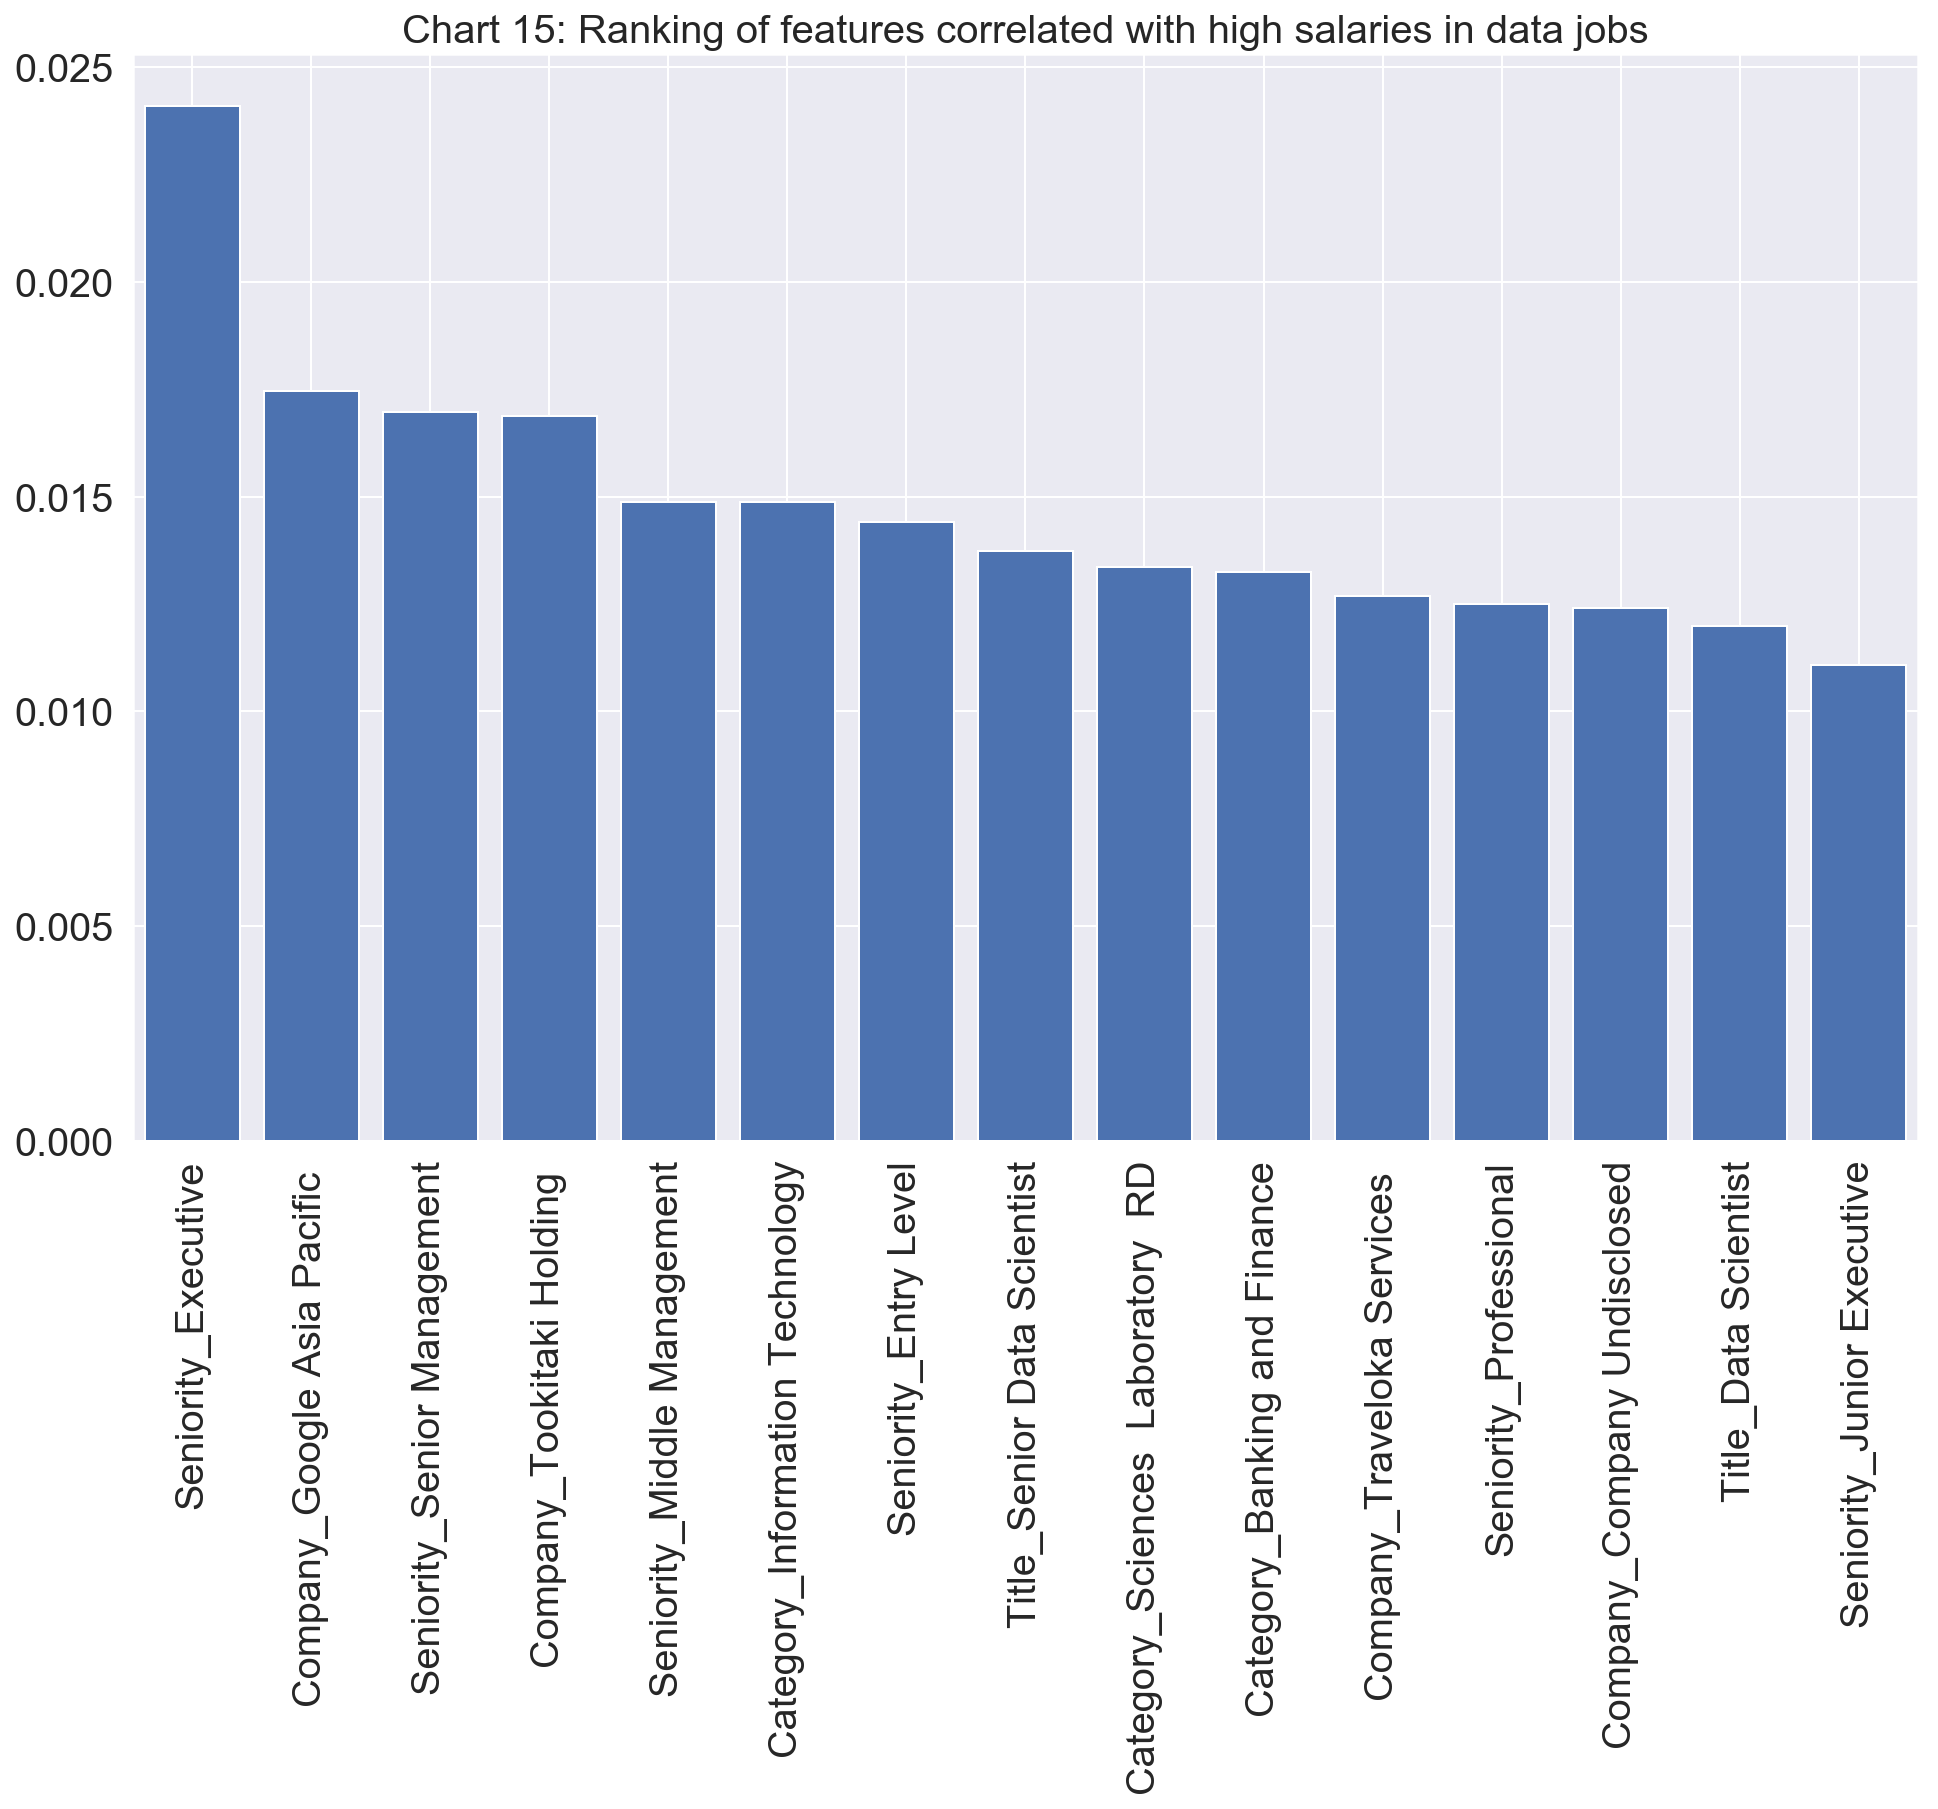

In [31]:
plt.figure(figsize=(16,10))
plt.bar(range(X_train.shape[1]), importances[indices])
plt.xticks(range(X_train.shape[1]), names, rotation=90)
plt.title('Chart 15: Ranking of features correlated with high salaries in data jobs', fontsize=20)
plt.xlim(-0.5, 14.5)
plt.show()

Again, seniority popped up as the most striking feature affecting high pay. Among the employers, Google and Traveloka stood out as those whose job postings correlate correlate strongly with high pay.

#### 1.5 WOULD ADDING MORE FEATURES IMPROVE THE MODEL?
Let's try running the RFC model with a fuller set of predictors and see if we get better performance.

In [32]:
more_cols = ['Company', 'Title', 'Seniority', 'Category', 'Address', 'Employment_Type']
new_predictors = pd.get_dummies(jobs[more_cols])

In [33]:
X_new = new_predictors
y_new = jobs['High_Salary_Or_Not']

In [34]:
X_new_train, X_new_test, y_new_train, y_new_test = train_test_split(X_new, y_new, stratify=y, random_state=42)

In [35]:
print((X_new_train.shape))
print((X_new_test.shape))

(609, 1227)
(203, 1227)


In [36]:
y_new_test.value_counts()

0    162
1     41
Name: High_Salary_Or_Not, dtype: int64

In [37]:
rfc_new = RandomForestClassifier(random_state=0, n_jobs=-1)

In [38]:
clf_new = GridSearchCV(rfc_new, rfc_grid, cv=5, scoring='roc_auc', verbose=1, n_jobs=-1)

In [39]:
clf_new.fit(X_new_train, y_new_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.6s finished
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [1000], 'criterion': ['entropy'], 'class_weight': ['balanced']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [40]:
clf_new.best_score_

0.8058509913538316

In [41]:
y_pred_new = clf_new.predict(X_new_test)

In [42]:
print("Accuracy Score:", accuracy_score(y_new_test, y_pred_new))
print("Precision Score :", precision_score(y_new_test, y_pred_new))
print("Recall Score:", recall_score(y_new_test, y_pred_new))
print("f1 Score:", f1_score(y_new_test, y_pred_new))

Accuracy Score: 0.8522167487684729
Precision Score : 0.7894736842105263
Recall Score: 0.36585365853658536
f1 Score: 0.4999999999999999


In [43]:
cm_new = confusion_matrix(y_new_test, y_pred_new)
cm_new

array([[158,   4],
       [ 26,  15]])

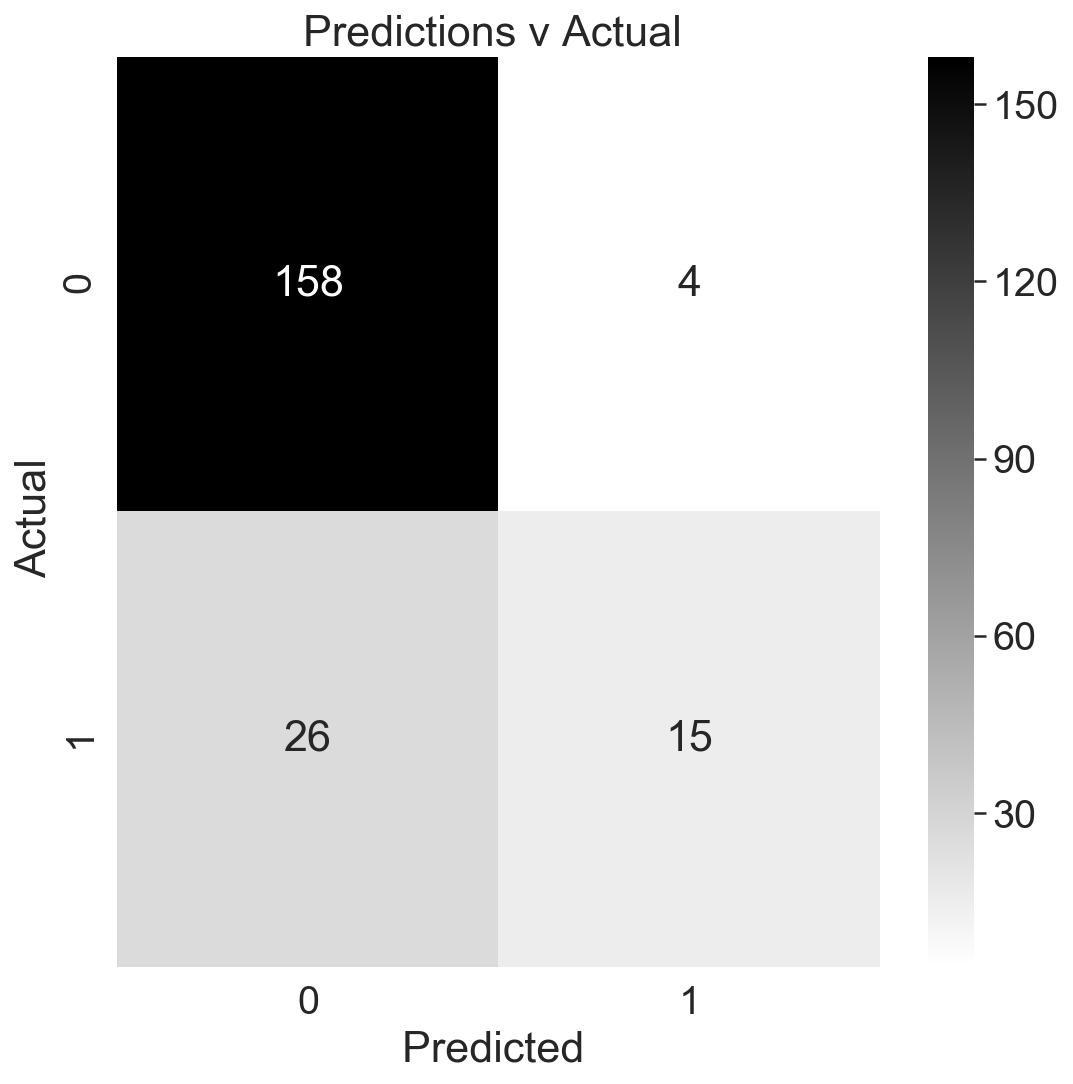

In [44]:
plt.figure(figsize=(8,8))
sns.heatmap(cm_new, annot=True, fmt="d", cmap="gist_gray_r")
sns.set(font_scale=1.8)
plt.title("Predictions v Actual ")
plt.ylabel("Actual ")
plt.xlabel("Predicted ")
plt.tight_layout()

### ANALYSIS:
Adding more features caused the RFC model's performance to dip a little. This time, it correctly predicted just 15 true positives instead of 16 previously.

As always, adding more predictors don't necessarily produce better outcomes. A simpler model with just the four initial predictors, chosen from careful data visualisation and observations, seems to work better.

#### 1.6 USING THE RESPONSIBILITIES COLUMN
Let's see if using a CountVectorizer-generated feature set for the Responsibilities columns would yield better results.

In [45]:
X_resp = jobs['Responsibilities']
y_resp = jobs['High_Salary_Or_Not']

In [46]:
X_resp_train, X_resp_test, y_resp_train, y_resp_test = train_test_split(X_resp, y_resp, random_state=42)

In [47]:
# Define a pipeline combining a text feature extractor with a simple classifier
models_resp = {
    "Naive Bayes": (
        Pipeline(
            [
                ("vect", CountVectorizer()),
                ("tfidf", TfidfTransformer()),
                ("clf", MultinomialNB()),
            ]
        ),
        {
            "vect__stop_words": ["english"],
            "vect__min_df": (1, 2),
            "vect__max_df": (0.5, 1.0),
            "vect__max_features": (None, 100, 200),
            "vect__ngram_range": ((1, 1), (1, 2)),  # unigrams or bigrams
            "tfidf__use_idf": (True, False),
            "tfidf__norm": ("l1", "l2"),
            "clf__alpha": (10, 1, 0.1, 0.01),
        },
    ),
    "LogReg": (
        Pipeline(
            [
                ("vect", CountVectorizer()),
                ("tfidf", TfidfTransformer()),
                ("clf", LogisticRegression()),
            ]
        ),
        {
            "vect__stop_words": ["english"],
            "vect__min_df": (1, 2),
            "vect__max_df": (0.5, 1.0),
            "vect__max_features": (None, 100, 200),
            "vect__ngram_range": ((1, 1), (1, 2)),  # unigrams or bigrams
            "tfidf__use_idf": (True, False),
            "tfidf__norm": ("l1", "l2"),
            "clf__penalty": ["l1", "l2"],
            "clf__C": np.logspace(-4, 4, 40),
            "clf__solver": ["liblinear"],
        },
    ),
    "LinearSVC": (
        Pipeline(
            [
                ("vect", CountVectorizer()),
                ("tfidf", TfidfTransformer()),
                ("clf", LinearSVC()),
            ]
        ),
        {
            "vect__stop_words": ["english"],
            "vect__min_df": (1, 2),
            "vect__max_df": (0.5, 1.0),
            "vect__max_features": (None, 100, 200),
            "vect__ngram_range": ((1, 1), (1, 2)),  # unigrams or bigrams
            "tfidf__use_idf": (True, False),
            "tfidf__norm": ("l1", "l2"),
            "clf__loss": ["squared_hinge"],
            "clf__C": [1.0],
            "clf__class_weight": [None],
        },
    ),
}

In [48]:
# WARNING: This would take a long time to re-run on a laptop. 
#Results pasted below for ref in case of accidental re-runs 
for name,(model,parameters) in models_resp.items():
    print('----- {} -----'.format(name))
    gs = GridSearchCV(model, parameters, cv=5, 
                      verbose=0, n_jobs=-1, scoring='roc_auc')
    gs.fit(X_resp_train, y_resp_train)
    print("Best Parameters:", gs.best_params_)
    print("Best Score:", gs.best_score_)
    y_pred_resp = gs.predict(X_resp_test)
    print("Precision Score :", precision_score(y_resp_test, y_pred_resp))
    print("Recall Score:", recall_score(y_resp_test, y_pred_resp))
    print("f1 Score:", f1_score(y_resp_test, y_pred_resp))    
    print('')
    
"""
----- Naive Bayes -----
Best Parameters: {'clf__alpha': 0.01, 'tfidf__norm': 'l1', 'tfidf__use_idf': True, 'vect__max_df': 0.5, 'vect__max_features': None, 'vect__min_df': 1, 'vect__ngram_range': (1, 1), 'vect__stop_words': 'english'}
Best Score: 0.7826425404887449

----- LogReg -----
Best Parameters: {'clf__C': 88.86238162743408, 'clf__penalty': 'l2', 'clf__solver': 'liblinear', 'tfidf__norm': 'l1', 'tfidf__use_idf': True, 'vect__max_df': 0.5, 'vect__max_features': None, 'vect__min_df': 1, 'vect__ngram_range': (1, 2), 'vect__stop_words': 'english'}
Best Score: 0.8003475485289425

----- LinearSVC -----
Best Parameters: {'clf__C': 1.0, 'clf__class_weight': None, 'clf__loss': 'squared_hinge', 'tfidf__norm': 'l1', 'tfidf__use_idf': True, 'vect__max_df': 0.5, 'vect__max_features': None, 'vect__min_df': 1, 'vect__ngram_range': (1, 2), 'vect__stop_words': 'english'}
Best Score: 0.7989085207153469

"""        

----- Naive Bayes -----


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best Parameters: {'clf__alpha': 0.01, 'tfidf__norm': 'l1', 'tfidf__use_idf': True, 'vect__max_df': 0.5, 'vect__max_features': None, 'vect__min_df': 1, 'vect__ngram_range': (1, 1), 'vect__stop_words': 'english'}
Best Score: 0.7826425404887449
Precision Score : 0.0
Recall Score: 0.0
f1 Score: 0.0

----- LogReg -----


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best Parameters: {'clf__C': 88.86238162743408, 'clf__penalty': 'l2', 'clf__solver': 'liblinear', 'tfidf__norm': 'l1', 'tfidf__use_idf': True, 'vect__max_df': 0.5, 'vect__max_features': None, 'vect__min_df': 1, 'vect__ngram_range': (1, 2), 'vect__stop_words': 'english'}
Best Score: 0.8003475485289425
Precision Score : 0.0
Recall Score: 0.0
f1 Score: 0.0

----- LinearSVC -----


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Best Parameters: {'clf__C': 1.0, 'clf__class_weight': None, 'clf__loss': 'squared_hinge', 'tfidf__norm': 'l1', 'tfidf__use_idf': True, 'vect__max_df': 0.5, 'vect__max_features': None, 'vect__min_df': 1, 'vect__ngram_range': (1, 2), 'vect__stop_words': 'english'}
Best Score: 0.7989085207153469
Precision Score : 0.0
Recall Score: 0.0
f1 Score: 0.0



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


"\n----- Naive Bayes -----\nBest Parameters: {'clf__alpha': 0.01, 'tfidf__norm': 'l1', 'tfidf__use_idf': True, 'vect__max_df': 0.5, 'vect__max_features': None, 'vect__min_df': 1, 'vect__ngram_range': (1, 1), 'vect__stop_words': 'english'}\nBest Score: 0.7826425404887449\n\n----- LogReg -----\nBest Parameters: {'clf__C': 88.86238162743408, 'clf__penalty': 'l2', 'clf__solver': 'liblinear', 'tfidf__norm': 'l1', 'tfidf__use_idf': True, 'vect__max_df': 0.5, 'vect__max_features': None, 'vect__min_df': 1, 'vect__ngram_range': (1, 2), 'vect__stop_words': 'english'}\nBest Score: 0.8003475485289425\n\n----- LinearSVC -----\nBest Parameters: {'clf__C': 1.0, 'clf__class_weight': None, 'clf__loss': 'squared_hinge', 'tfidf__norm': 'l1', 'tfidf__use_idf': True, 'vect__max_df': 0.5, 'vect__max_features': None, 'vect__min_df': 1, 'vect__ngram_range': (1, 2), 'vect__stop_words': 'english'}\nBest Score: 0.7989085207153469\n\n"

#### 1.7 USING THE REQUIREMENTS COLUMN
Let's see if using the Requirements column would make any difference.

In [49]:
X_req = jobs['Requirements']
y_req = jobs['High_Salary_Or_Not']

In [50]:
X_req_train, X_req_test, y_req_train, y_req_test = train_test_split(X_req, y_req, random_state=42)

In [51]:
# I'll comment out some of the parameters used in the Responsibilities section to speed things up 
models_req = {
    "Naive Bayes": (
        Pipeline(
            [
                ("vect", CountVectorizer()),
                ("tfidf", TfidfTransformer()),
                ("clf", MultinomialNB()),
            ]
        ),
        {
            "vect__stop_words": ["english"],
            "vect__min_df": (1, 2),
            "vect__max_df": (0.5, 1.0),
            "vect__max_features": (None, 100, 200),
            "vect__ngram_range": ((1, 1), (1, 2)),  # unigrams or bigrams
            "tfidf__use_idf": (True, False),
            #"tfidf__norm": ("l1", "l2"),
            "clf__alpha": (10, 1, 0.1, 0.01),
        },
    ),
    "LogReg": (
        Pipeline(
            [
                ("vect", CountVectorizer()),
                ("tfidf", TfidfTransformer()),
                ("clf", LogisticRegression()),
            ]
        ),
        {
            "vect__stop_words": ["english"],
            "vect__min_df": (1, 2),
            "vect__max_df": (0.5, 1.0),
            "vect__max_features": (None, 100, 200),
            "vect__ngram_range": ((1, 1), (1, 2)),  # unigrams or bigrams
            "tfidf__use_idf": (True, False),
            #"tfidf__norm": ("l1", "l2"),
            "clf__penalty": ["l1", "l2"],
            "clf__C": np.logspace(-4, 4, 40),
            "clf__solver": ["liblinear"],
        },
    ),
    "LinearSVC": (
        Pipeline(
            [
                ("vect", CountVectorizer()),
                ("tfidf", TfidfTransformer()),
                ("clf", LinearSVC()),
            ]
        ),
        {
            "vect__stop_words": ["english"],
            "vect__min_df": (1, 2),
            "vect__max_df": (0.5, 1.0),
            "vect__max_features": (None, 100, 200),
            "vect__ngram_range": ((1, 1), (1, 2)),  # unigrams or bigrams
            "tfidf__use_idf": (True, False),
            #"tfidf__norm": ("l1", "l2"),
            "clf__loss": ["squared_hinge"],
            "clf__C": [1.0],
            "clf__class_weight": [None],
        },
    ),
}

In [52]:
for name,(model,parameters) in models_req.items():
    print('----- {} -----'.format(name))
    gs = GridSearchCV(model, parameters, cv=5, 
                      verbose=0, n_jobs=-1, scoring='roc_auc')
    gs.fit(X_req_train, y_req_train)
    print("Best Parameters:", gs.best_params_)
    print("Best Score:", gs.best_score_)
    y_pred_req = gs.predict(X_req_test)
    print("Precision Score :", precision_score(y_req_test, y_pred_req))
    print("Recall Score:", recall_score(y_req_test, y_pred_req))
    print("f1 Score:", f1_score(y_req_test, y_pred_req))    
    print('')
    
"""
----- Naive Bayes -----
Best Parameters: {'clf__alpha': 0.01, 'tfidf__use_idf': False, 'vect__max_df': 1.0, 'vect__max_features': None, 'vect__min_df': 2, 'vect__ngram_range': (1, 1), 'vect__stop_words': 'english'}
Best Score: 0.7656449350640521
Precision Score : 0.8
Recall Score: 0.2727272727272727
f1 Score: 0.4067796610169491

----- LogReg -----
Best Parameters: {'clf__C': 1.2663801734674023, 'clf__penalty': 'l2', 'clf__solver': 'liblinear', 'tfidf__use_idf': True, 'vect__max_df': 0.5, 'vect__max_features': None, 'vect__min_df': 2, 'vect__ngram_range': (1, 1), 'vect__stop_words': 'english'}
Best Score: 0.7845978007109176
Precision Score : 1.0
Recall Score: 0.045454545454545456
f1 Score: 0.08695652173913045

----- LinearSVC -----
Best Parameters: {'clf__C': 1.0, 'clf__class_weight': None, 'clf__loss': 'squared_hinge', 'tfidf__use_idf': True, 'vect__max_df': 0.5, 'vect__max_features': None, 'vect__min_df': 1, 'vect__ngram_range': (1, 2), 'vect__stop_words': 'english'}
Best Score: 0.7638976308735816
Precision Score : 0.8
Recall Score: 0.2727272727272727
f1 Score: 0.4067796610169491

"""        

----- Naive Bayes -----


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best Parameters: {'clf__alpha': 0.01, 'tfidf__use_idf': False, 'vect__max_df': 1.0, 'vect__max_features': None, 'vect__min_df': 2, 'vect__ngram_range': (1, 1), 'vect__stop_words': 'english'}
Best Score: 0.7656449350640521
Precision Score : 0.8
Recall Score: 0.2727272727272727
f1 Score: 0.4067796610169491

----- LogReg -----


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best Parameters: {'clf__C': 1.2663801734674023, 'clf__penalty': 'l2', 'clf__solver': 'liblinear', 'tfidf__use_idf': True, 'vect__max_df': 1.0, 'vect__max_features': None, 'vect__min_df': 1, 'vect__ngram_range': (1, 1), 'vect__stop_words': 'english'}
Best Score: 0.7845978007109176
Precision Score : 1.0
Recall Score: 0.045454545454545456
f1 Score: 0.08695652173913045

----- LinearSVC -----
Best Parameters: {'clf__C': 1.0, 'clf__class_weight': None, 'clf__loss': 'squared_hinge', 'tfidf__use_idf': True, 'vect__max_df': 0.5, 'vect__max_features': None, 'vect__min_df': 1, 'vect__ngram_range': (1, 2), 'vect__stop_words': 'english'}
Best Score: 0.7638976308735816
Precision Score : 0.8
Recall Score: 0.2727272727272727
f1 Score: 0.4067796610169491



"\n----- Naive Bayes -----\nBest Parameters: {'clf__alpha': 0.01, 'tfidf__use_idf': False, 'vect__max_df': 1.0, 'vect__max_features': None, 'vect__min_df': 2, 'vect__ngram_range': (1, 1), 'vect__stop_words': 'english'}\nBest Score: 0.7656449350640521\nPrecision Score : 0.8\nRecall Score: 0.2727272727272727\nf1 Score: 0.4067796610169491\n\n----- LogReg -----\nBest Parameters: {'clf__C': 1.2663801734674023, 'clf__penalty': 'l2', 'clf__solver': 'liblinear', 'tfidf__use_idf': True, 'vect__max_df': 0.5, 'vect__max_features': None, 'vect__min_df': 2, 'vect__ngram_range': (1, 1), 'vect__stop_words': 'english'}\nBest Score: 0.7845978007109176\nPrecision Score : 1.0\nRecall Score: 0.045454545454545456\nf1 Score: 0.08695652173913045\n\n----- LinearSVC -----\nBest Parameters: {'clf__C': 1.0, 'clf__class_weight': None, 'clf__loss': 'squared_hinge', 'tfidf__use_idf': True, 'vect__max_df': 0.5, 'vect__max_features': None, 'vect__min_df': 1, 'vect__ngram_range': (1, 2), 'vect__stop_words': 'english'}

### ANALYSIS:
None of the 6 models using a countvectorized feature set performed better than the simpler Random Forest model with four predictors. I won't proceed further with these models. 

#### 1.8 COMBINING COUNTERVECTORIZER FEATURE SET WITH OTHER FEATURES
Finally, let's try combining a countervectorizer set, using the Responsibilities column, with the four initial predictors to see if there's any difference to performance. 

In [53]:
vect = CountVectorizer(stop_words="english", max_features=200, ngram_range=(1,2))
X_train_dtm = vect.fit_transform(X_resp_train)
X_test_dtm = vect.transform(X_resp_test)

In [54]:
print((X_train_dtm.shape))
print((X_test_dtm.shape))

(609, 200)
(203, 200)


In [55]:
# converting the earlier X_train, X_test dummified set to sparse matrices so that they 
#can be horizontally stacked with the DTM set above
X_train_extra = sp.sparse.csr_matrix(X_train)
X_test_extra = sp.sparse.csr_matrix(X_test)

In [56]:
print((X_train_extra.shape))
print((X_test_extra.shape))

(609, 1004)
(203, 1004)


In [57]:
# We have to hstack instead of concating the two sets in this case as they are no longer pandas DFs
X_train_full = hstack([X_train_dtm, X_train_extra]).toarray()
X_test_full = hstack([X_test_dtm, X_test_extra]).toarray()

In [58]:
print(X_train_full.shape)
print(X_test_full.shape)

(609, 1204)
(203, 1204)


In [59]:
models_full = {
    "Naive Bayes": (MultinomialNB(), {"alpha": [1.0], "fit_prior": [True]}),
    "LogReg": (
        LogisticRegression(),
        {"penalty": ["l1", "l2"], "C": np.logspace(-4, 4, 40), "solver": ["liblinear"]},
    ),
    "Random Forest": (
        RandomForestClassifier(),
        {"n_estimators": [200, 500, 1000], "criterion": ["gini", "entropy"]},
    ),
}

In [60]:
for name,(model,parameters) in models_full.items():
    print('----- {} -----'.format(name))
    gs = GridSearchCV(model, parameters, cv=5, 
                      verbose=0, n_jobs=-1, scoring='roc_auc')
    gs.fit(X_train_full, y_train)
    print("Best Parameters:", gs.best_params_)
    print("Best Score:", gs.best_score_)
    y_pred_full = gs.predict(X_test_full)
    print("Precision Score :", precision_score(y_test, y_pred_full))
    print("Recall Score:", recall_score(y_test, y_pred_full))
    print("f1 Score:", f1_score(y_test, y_pred_full))    
    print('')

----- Naive Bayes -----
Best Parameters: {'alpha': 1.0, 'fit_prior': True}
Best Score: 0.6415324766508774
Precision Score : 0.5
Recall Score: 0.2926829268292683
f1 Score: 0.3692307692307692

----- LogReg -----


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best Parameters: {'C': 6235.507341273912, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.7424633397787196
Precision Score : 0.625
Recall Score: 0.4878048780487805
f1 Score: 0.547945205479452

----- Random Forest -----
Best Parameters: {'criterion': 'entropy', 'n_estimators': 1000}
Best Score: 0.657558204820025
Precision Score : 0.5
Recall Score: 0.04878048780487805
f1 Score: 0.08888888888888888



#### The results are again no better than the simpler Random Forest-4-Predictors model. Let's try one last model, using the RFC model with the combined set of predictors.

In [61]:
rfc_final = RandomForestClassifier(random_state=42, n_jobs=-1)

In [62]:
clf_final = GridSearchCV(rfc_final, rfc_grid, cv=5, scoring='roc_auc', verbose=1, n_jobs=-1)

In [63]:
clf_final.fit(X_train_full, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.1s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [1000], 'criterion': ['entropy'], 'class_weight': ['balanced']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [64]:
clf_final.best_score_

0.6461503954924444

In [65]:
y_pred_final = clf_final.predict(X_test_full)

In [66]:
print("Accuracy Score:", accuracy_score(y_test, y_pred_final))
print("Precision Score :", precision_score(y_test, y_pred_final))
print("Recall Score:", recall_score(y_test, y_pred_final))
print("f1 Score:", f1_score(y_test, y_pred_final))

Accuracy Score: 0.7980295566502463
Precision Score : 0.5
Recall Score: 0.07317073170731707
f1 Score: 0.1276595744680851


### ANALYSIS: 
Less is indeed more in addressing this question. Using four well-chosen predictors and a relatively simple RFC model, I could get better predictions of high salaries compared to the more messy methods involving strange combinations of countvectorizer feature and dummified feature sets.

For further work, I could potentially try to use boosting techniques with the four predictors. 

### But I'll end Question 1 here and move on to Question 2. This will be in the next notebook, 3.0.